# 2) Compute features for random parameters

Using the generated random parameters, we next compute responses and features for 3 different feature sets:

- 'bap': features extracted from somatic recording with 3 different steps + a pulse response measured at the soma plus two locations on the apical dendrite (Backpropagating Action Potential)

- 'soma': features extracted from somatic recording with 3 different steps

- 'extra': features extracted from somatic recording with 3 different steps and from mean extracellular action potential

Computed features are saved in the `config/features/` folder for each parameter set and are ready to be used for optimization.

In [7]:
%load_ext autoreload
%autoreload

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
import MEAutility as mu
import json
import numpy
import time
import numpy as np
import pandas as pd
import LFPy

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import l5pc_model
import l5pc_evaluator
import l5pc_plot

In [ ]:
save_features = False

### Define extracellular electrodes

Importantly, if the electrode design changes, new features need to be generated. 

However, a subset of channels can be selected before running the optimization procedure.

In [9]:
mea_positions = np.zeros((20, 3))
mea_positions[:, 2] = 20
mea_positions[:, 1] = np.linspace(-500, 1000, 20)
probe = mu.return_mea(info={'pos': list([list(p) for p in mea_positions]), 'center': False, 'plane': 'xy'})
electrode = LFPy.RecExtElectrode(probe=probe, method='linesource')

<IPython.core.display.Javascript object>


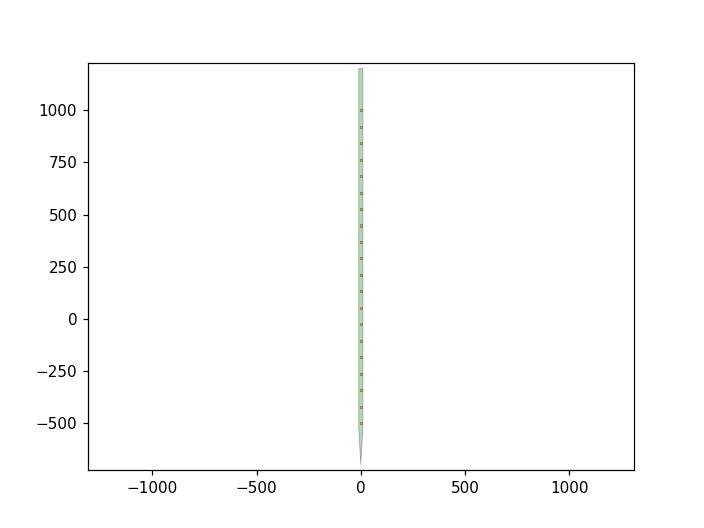

In [10]:
ax = mu.plot_probe(probe)

### Compute features

Features for the different feature sets ('bap', 'soma', 'extra') are listed in the `config/feature_list.json` file.

Here we loop through the different feature sets and random parameters, compute the corresponding features and save them in a `json` file that will be later used to construct the `CellEvaluator`.


In [12]:
random_params_file = 'config/params/random.csv'
random_params = pd.read_csv(random_params_file, index_col='index')
params = random_params.iloc[0].to_dict()

In [14]:
feature_sets = ["soma", "bap", "extra"] # 'soma'/'bap'
channels = None

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

for feature_set in feature_sets:
    print(f'Feature set {feature_set}')
    responses = []

    if feature_set == "extra":
        fitness_protocols = l5pc_evaluator.define_protocols(electrode) 
    else:
        fitness_protocols = l5pc_evaluator.define_protocols() 

    if feature_set == "extra":
        sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True, electrode=electrode)
    else:
        sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True)

    for i, (index, params) in enumerate(random_params.iterrows()):
        print(f'{i+1} / {len(random_params)}, {index}')
        
        feature_folder = f'config/features/{index}'
        feature_file, response = l5pc_evaluator.compute_feature_values(params, l5pc_cell, fitness_protocols, sim, 
                                                                       feature_set=feature_set, probe=probe, 
                                                                       channels=channels,
                                                                       feature_folder=feature_folder)
        responses.append(response)
        
        if save_features:
            # save probe yaml in the feature folder
            with (Path(feature_folder) / 'probe.json').open('w') as f:
                json.dump(probe.info, f, indent=4)

Feature set soma
1 / 30, random_0
gNaTs2_tbar_NaTs2_t.apical         0.028444
gSKv3_1bar_SKv3_1.apical           0.004417
gImbar_Im.apical                   0.000161
gNaTa_tbar_NaTa_t.axonal           3.471240
gK_Tstbar_K_Tst.axonal             0.071471
gamma_CaDynamics_E2.axonal         0.003161
gNap_Et2bar_Nap_Et2.axonal         0.006423
gSK_E2bar_SK_E2.axonal             0.007528
gCa_HVAbar_Ca_HVA.axonal           0.000812
gK_Pstbar_K_Pst.axonal             0.920779
gSKv3_1bar_SKv3_1.axonal           0.819891
decay_CaDynamics_E2.axonal       234.163222
gCa_LVAstbar_Ca_LVAst.axonal       0.007412
gamma_CaDynamics_E2.somatic        0.000650
gSKv3_1bar_SKv3_1.somatic          0.339137
gSK_E2bar_SK_E2.somatic            0.007840
gCa_HVAbar_Ca_HVA.somatic          0.000932
gNaTs2_tbar_NaTs2_t.somatic        0.928773
decay_CaDynamics_E2.somatic      187.416285
gCa_LVAstbar_Ca_LVAst.somatic      0.000372
Name: random_0, dtype: float64
2 / 30, random_1
gNaTs2_tbar_NaTs2_t.apical         0.0

<IPython.core.display.Javascript object>


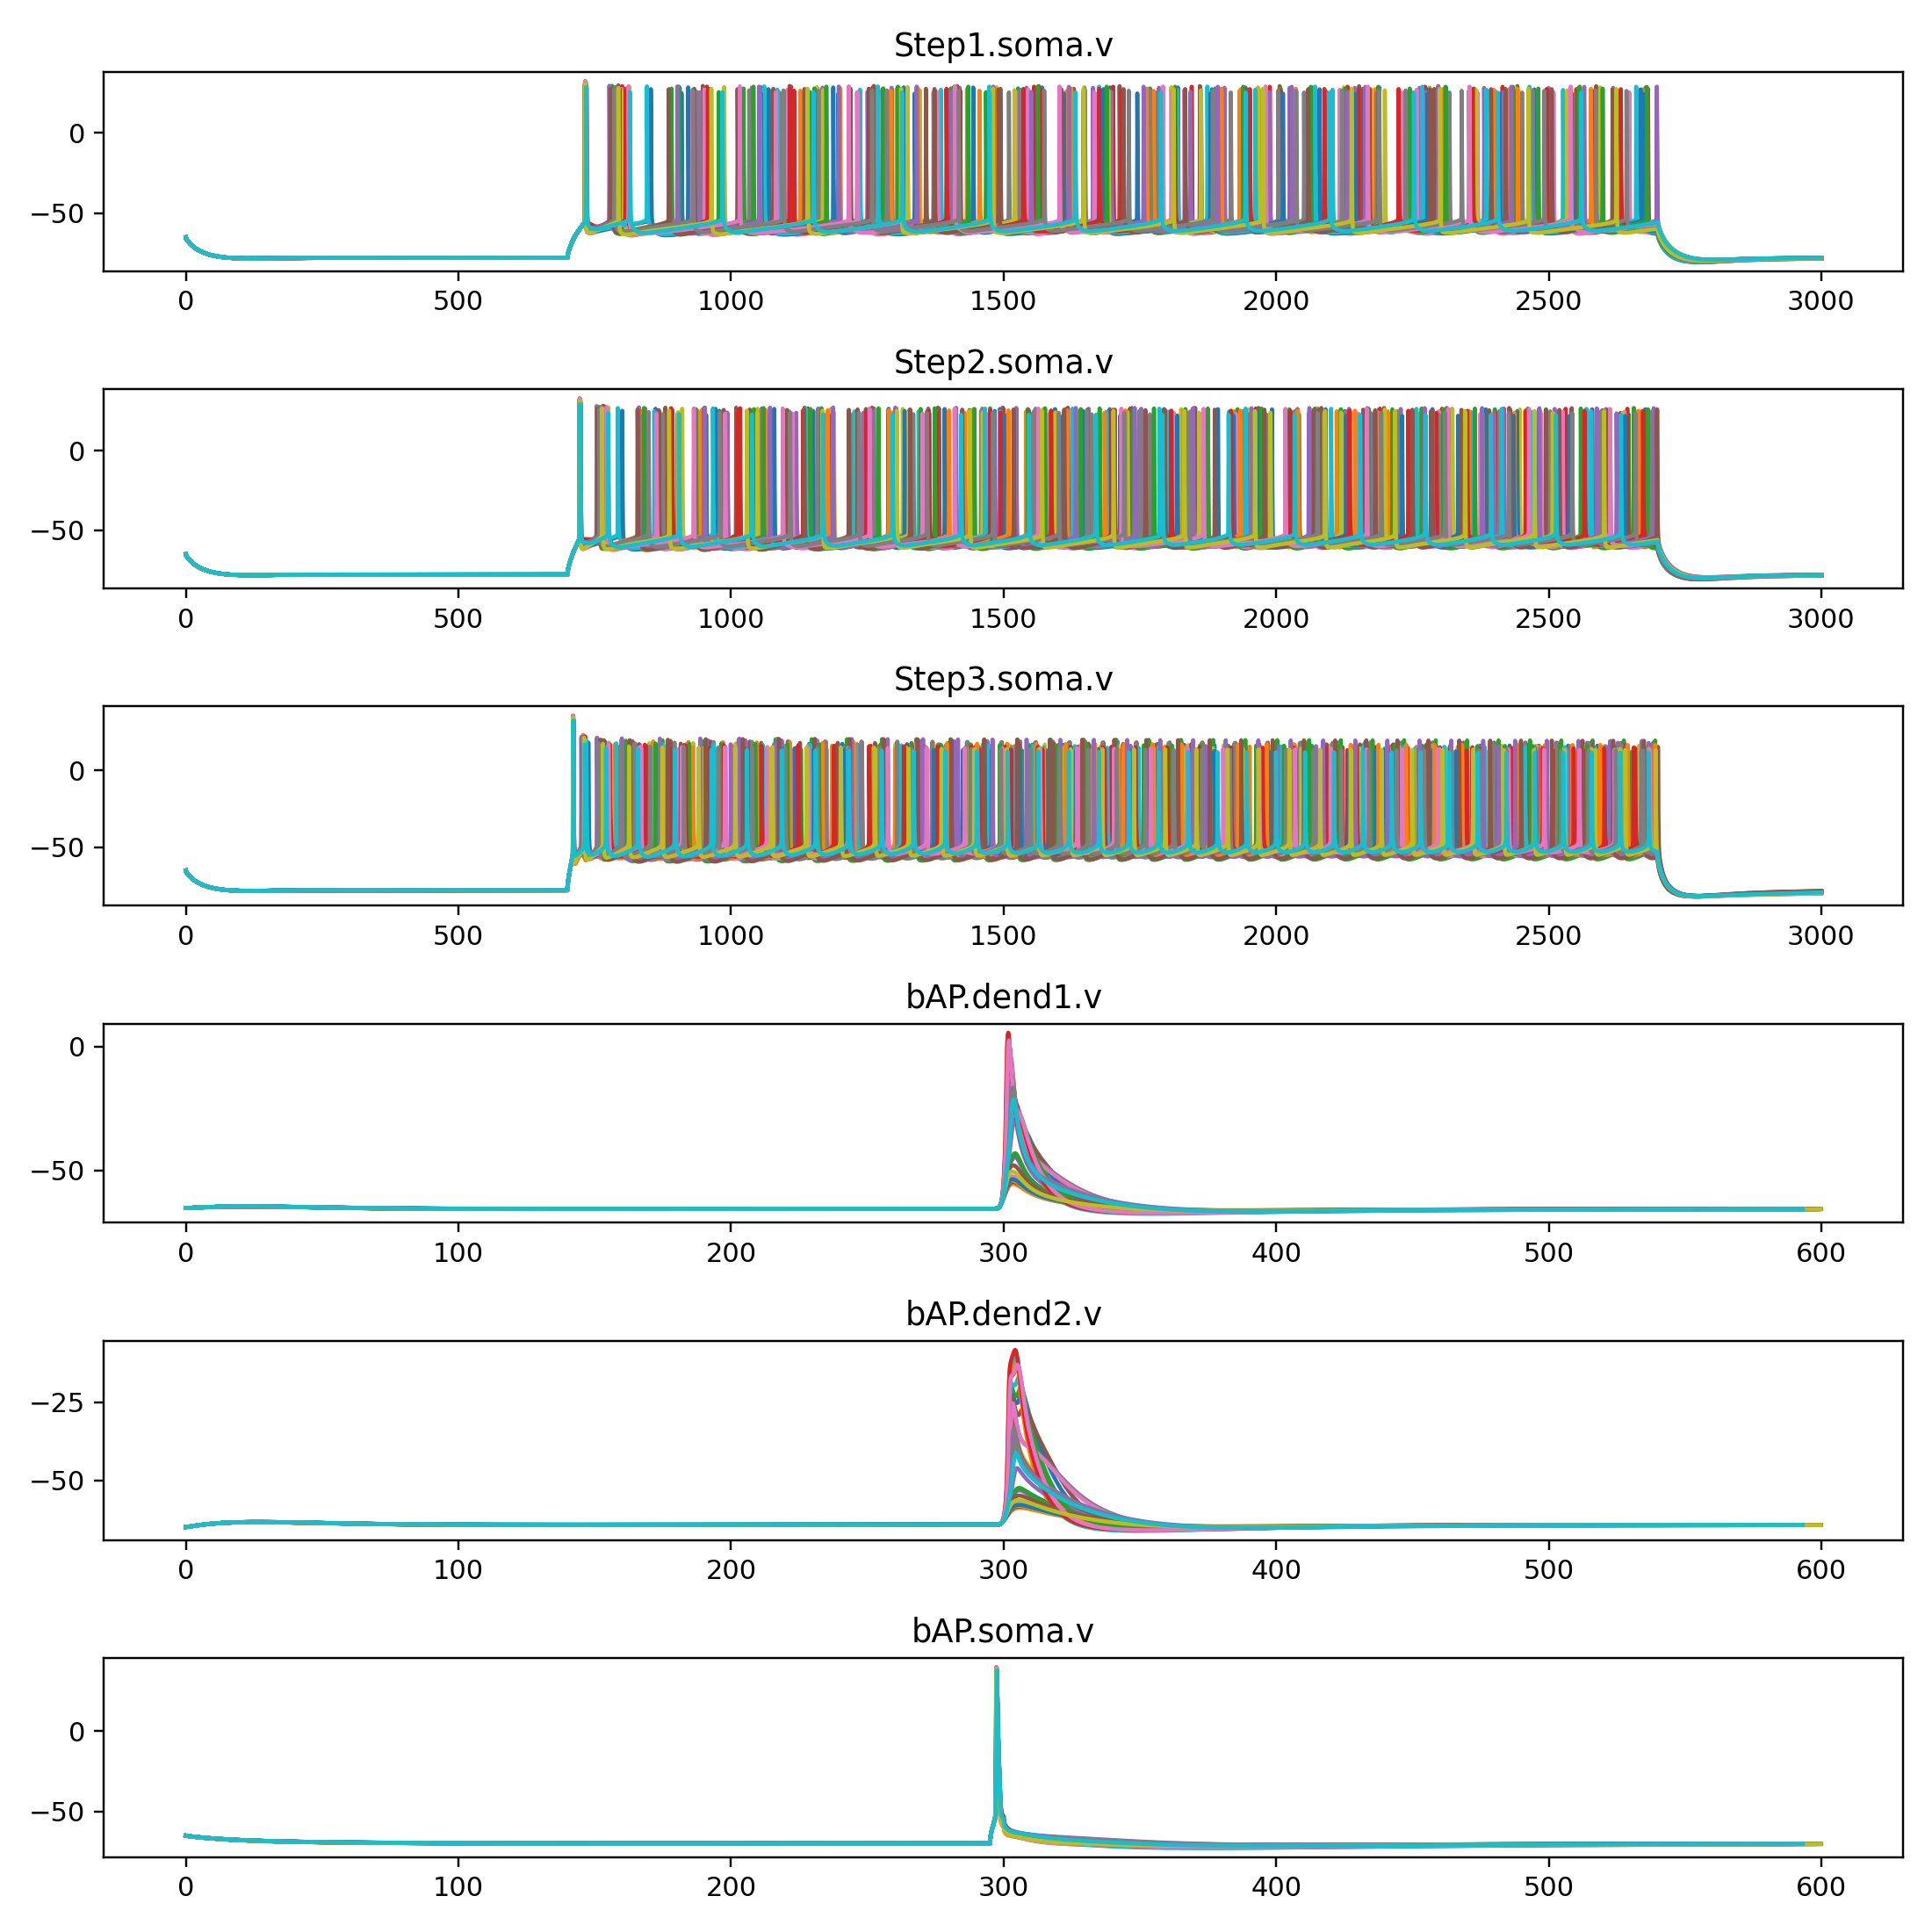

In [76]:
l5py_plot.plot_multiple_responses(responses)